# Replicate Paper Results: 1D and 2D Spectroscopy Data Processing

This notebook loads and plots both 1D and 2D spectroscopy data from pickle files to replicate paper results.

# Generalized Functions for Data Loading

In [ ]:
# =============================
# IMPORTS
# =============================
import os
import sys
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Project-specific imports
from config.paths import DATA_DIR, FIGURES_DIR
from src.spectroscopy.post_processing import extend_and_plot_results
from src.visualization.plotting import Plot_2d_El_field, Plot_fixed_tau_T
from src.visualization import mpl_tex_settings

In [ ]:
# =============================
# GENERALIZED DATA LOADING FUNCTIONS
# =============================

def find_latest_file(data_subdir: str, file_pattern: str = "*.pkl") -> Path:
    """Find the most recent file matching pattern in a data subdirectory.
    
    Args:
        data_subdir: Subdirectory within DATA_DIR (e.g., '1d_spectroscopy', 'raw/2d_spectroscopy')
        file_pattern: Glob pattern for file matching
    
    Returns:
        Path to the latest file or None if not found
    """
    data_dir = DATA_DIR / data_subdir
    
    if not data_dir.exists():
        print(f"❌ Data directory does not exist: {data_dir}")
        return None
    
    # Look for files matching the pattern
    files = list(data_dir.glob(file_pattern))
    
    # For 2D data, also look for compressed files
    if "2d_spectroscopy" in data_subdir:
        files.extend(list(data_dir.glob("*.pkl.gz")))
    
    if not files:
        print(f"❌ No files matching '{file_pattern}' found in {data_dir}")
        return None
    
    # Get the most recent file
    latest_file = max(files, key=lambda p: p.stat().st_mtime)
    print(f"✅ Found latest file: {latest_file.name}")
    return latest_file


def load_pickle_file(filepath: Path) -> dict:
    """Load data from pickle file (supports both .pkl and .pkl.gz).
    
    Args:
        filepath: Path to the pickle file
    
    Returns:
        Dictionary containing the loaded data or None if error
    """
    print(f"Loading data from: {filepath.name}")
    
    try:
        if filepath.suffix == ".gz":
            # Handle compressed pickle files
            with gzip.open(filepath, "rb") as f:
                data = pickle.load(f)
        else:
            # Handle regular pickle files
            with open(filepath, "rb") as f:
                data = pickle.load(f)
        
        print(f"✅ Data loaded successfully!")
        return data
    
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None


def create_output_directory(subdir: str) -> Path:
    """Create output directory for figures.
    
    Args:
        subdir: Subdirectory name within FIGURES_DIR
    
    Returns:
        Path to the created output directory
    """
    output_dir = FIGURES_DIR / subdir
    os.makedirs(output_dir, exist_ok=True)
    return output_dir


from typing import Dict, Any
def average_data_1d(data_dir: str, file_pattern: str = "*.pkl", output_filename: str = "averaged_data.pkl") -> Dict[str, Any]:
    """Average data from multiple pickle files in a directory.
    
    Args:
        data_dir: Directory containing pickle files to process
        file_pattern: Pattern to match files (e.g., "*.pkl", "1d_data_*.pkl")
        output_filename: Name of the output file to save averaged data
        
    Returns:
        Dictionary containing the averaged data
    """
    # Convert to Path object for consistency
    data_path = Path(data_dir)
    
    # Get all matching pickle files in the directory
    pkl_files = list(data_path.glob(file_pattern))
    
    # Also look for compressed files if applicable
    if "pkl" in file_pattern:
        compressed_pattern = file_pattern.replace(".pkl", ".pkl.gz")
        pkl_files.extend(list(data_path.glob(compressed_pattern)))
    
    if not pkl_files:
        print(f"❌ No files matching '{file_pattern}' found in {data_dir}")
        return None
    
    pkl_files.sort()  # Sort for consistent processing
    print(f"Found {len(pkl_files)} pickle files to average.")
    
    # Initialize variables to store accumulated data
    sum_data_avg = None
    total_n_freqs = 0
    first_file_data = None
    
    # Process each file and accumulate data
    for i, file_path in enumerate(pkl_files):
        # Use the existing load_pickle_file function
        loaded_data = load_pickle_file(file_path)
        
        if loaded_data is not None:
            # Store data from the first file to use as template
            if i == 0:
                first_file_data = loaded_data
                # Initialize sum_data_avg with the right shape
                sum_data_avg = loaded_data['data_avg'].copy()
            else:
                # Add data_avg from current file
                sum_data_avg += loaded_data['data_avg']
            
            # Accumulate n_freqs
            total_n_freqs += loaded_data['n_freqs']
            
            print(f"✅ Processed file {i+1}/{len(pkl_files)}")
        else:
            print(f"❌ Skipping file due to load error: {file_path.name}")
    
    # Check if we have valid data to average
    if first_file_data is None or sum_data_avg is None:
        print("❌ No valid data files were processed.")
        return None
        
    # Count successfully processed files (might be less than total if some failed)
    processed_count = sum(1 for f in pkl_files if load_pickle_file(f) is not None)
    
    if processed_count == 0:
        print("❌ No files were successfully processed.")
        return None
    
    # Create averaged data dictionary
    averaged_data = {
        't_det_vals': first_file_data['t_det_vals'],
        'data_avg': sum_data_avg / processed_count,  # Average the accumulated data
        'tau_coh': first_file_data['tau_coh'],
        'T_wait': first_file_data['T_wait'],
        'system': first_file_data['system'],
        'n_freqs': total_n_freqs
    }
    
    # Save averaged data to output file
    output_path = data_path / output_filename
    with open(output_path, 'wb') as f:
        pickle.dump(averaged_data, f)
    
    print(f"✅ Averaged data saved to: {output_path}")
    print(f"  - Averaged across {processed_count} files")
    print(f"  - Total frequencies: {total_n_freqs}")
    
    return averaged_data

def average_data_2d(data_dir: str, file_pattern: str = "*d.pkl", output_filename: str = "averaged_2d_data.pkl") -> Dict[str, Any]:
    """Average 2D spectroscopy data from multiple pickle files in a directory.
    
    Args:
        data_dir: Directory containing pickle files to process
        file_pattern: Pattern to match files (e.g., "*d.pkl", "2d_data_*.pkl")
        output_filename: Name of the output file to save averaged data
        
    Returns:
        Dictionary containing the averaged data
    """
    # Convert to Path object for consistency
    data_path = Path(data_dir)
    
    # Get all matching pickle files in the directory
    pkl_files = list(data_path.glob(file_pattern))
    
    # Also look for compressed files if applicable
    if "pkl" in file_pattern:
        compressed_pattern = file_pattern.replace(".pkl", ".pkl.gz")
        pkl_files.extend(list(data_path.glob(compressed_pattern)))
    
    if not pkl_files:
        print(f"❌ No files matching '{file_pattern}' found in {data_dir}")
        return None
    
    pkl_files.sort()  # Sort for consistent processing
    print(f"Found {len(pkl_files)} pickle files to average.")
    
    # Initialize variables to store accumulated data
    sum_two_d_datas = None
    total_n_freqs = 0
    first_file_data = None
    processed_count = 0
    
    # Process each file and accumulate data
    for i, file_path in enumerate(pkl_files):
        # Use the existing load_pickle_file function
        loaded_data = load_pickle_file(file_path)
        
        if loaded_data is not None:
            # Store data from the first file to use as template
            if i == 0:
                first_file_data = loaded_data
                # Initialize sum_two_d_datas with the right shape AND dtype
                # For 2D data: two_d_datas is a list of arrays, one for each T_wait time
                # Use astype(complex) to ensure we preserve complex values
                sum_two_d_datas = [arr.copy().astype(complex) for arr in loaded_data['two_d_datas']]
            else:
                # Add corresponding 2D arrays for each T_wait time
                for j, arr in enumerate(loaded_data['two_d_datas']):
                    sum_two_d_datas[j] += arr.astype(complex)
            
            # Accumulate n_freqs
            total_n_freqs += loaded_data['n_freqs']
            processed_count += 1
            
            print(f"✅ Processed file {i+1}/{len(pkl_files)}: {file_path.name}")
        else:
            print(f"❌ Skipping file due to load error: {file_path.name}")
    
    # Check if we have valid data to average
    if first_file_data is None or sum_two_d_datas is None:
        print("❌ No valid data files were processed.")
        return None
        
    if processed_count == 0:
        print("❌ No files were successfully processed.")
        return None
    
    # Create averaged data dictionary
    averaged_data = {
        'times': first_file_data['times'],
        'times_T': first_file_data['times_T'],
        'system': first_file_data['system'],
        # Calculate average for each 2D array in the list
        'two_d_datas': [arr / processed_count for arr in sum_two_d_datas],
        'n_times_T': first_file_data['n_times_T'],
        'n_phases': first_file_data['n_phases'],
        'n_freqs': total_n_freqs  # Sum of all n_freqs values
    }
    
    # Save averaged data to output file
    output_path = data_path / output_filename
    with open(output_path, 'wb') as f:
        pickle.dump(averaged_data, f)
    
    print(f"✅ Averaged 2D data saved to: {output_path}")
    print(f"  - Averaged across {processed_count} files")
    print(f"  - Total frequencies: {total_n_freqs}")
    print(f"  - Number of T wait times: {len(averaged_data['two_d_datas'])}")
    print(f"  - Shape of each 2D array: {averaged_data['two_d_datas'][0].shape}")
    
    return averaged_data


In [ ]:
# =============================
# AVERAGE SIMULATION DATA FROM MULTIPLE PICKLE FILES
# =============================

# Example usage:
# Set data_dir to the directory containing pickle files to average
# Use pathlib for path operations
data_dir = DATA_DIR / "2d_spectroscopy" / "new_echo_signal" / "100fs"
averaged_data = average_data_2d(
    data_dir,
    file_pattern="2d_data_*.pkl",  # Optional: specify pattern to match specific files
    output_filename="2d_data_averaged.pkl"
)

Found 20 pickle files to average.
Loading data from: 2d_data_averaged.pkl
✅ Data loaded successfully!
✅ Processed file 1/20: 2d_data_averaged.pkl
Loading data from: 2d_data_tmax_100_dt_0.1_T1_ph4_freq1_20250605_144706.pkl
✅ Data loaded successfully!


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Found 7 pickle files to average.
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq10_20250606_163430.pkl
✅ Data loaded successfully!
✅ Processed file 1/7
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq10_20250606_163448.pkl
✅ Data loaded successfully!
✅ Processed file 2/7
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq10_20250606_163507.pkl
✅ Data loaded successfully!
✅ Processed file 3/7
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq10_20250606_164058.pkl
✅ Data loaded successfully!
✅ Processed file 4/7
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq2_20250606_164350.pkl
✅ Data loaded successfully!
✅ Processed file 5/7
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq3_20250606_164408.pkl
✅ Data loaded successfully!
✅ Processed file 6/7
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq4_20250606_164426.pkl
✅ Data loaded successfully!
✅ Processed file 7/7
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq10_20250606_163430.pkl
✅ Data loaded successfully!

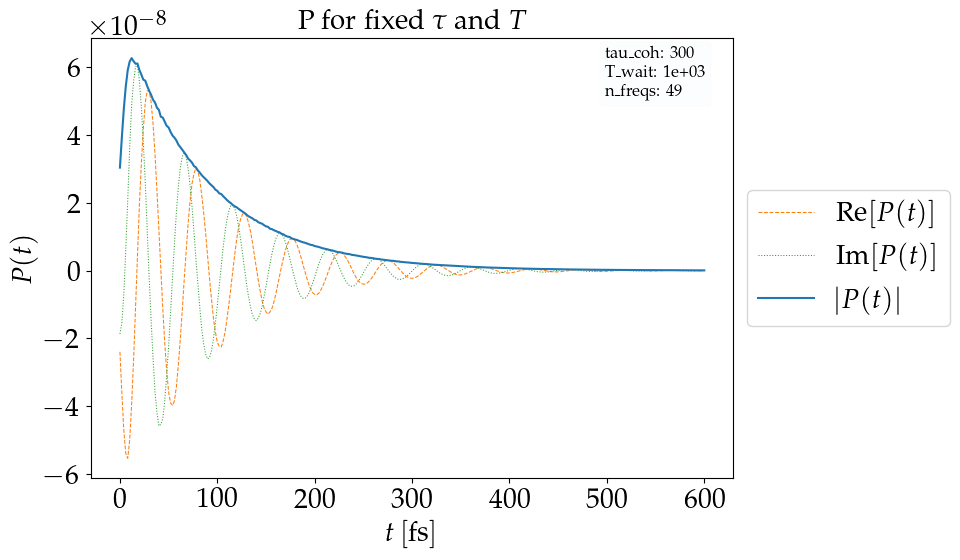

In [ ]:
# =============================
# AVERAGE SIMULATION DATA FROM MULTIPLE PICKLE FILES
# =============================

# Example usage:
# Set data_dir to the directory containing pickle files to average
# Use pathlib for path operations
data_dir = DATA_DIR / "1d_spectroscopy" / "Delta_cm_200"
averaged_data = average_data_1d(
    data_dir,
    file_pattern="1d_data_*.pkl",  # Optional: specify pattern to match specific files
    output_filename="1d_data_averaged.pkl"
)

# You can then use the averaged data for plotting or further analysis
# For example:
if averaged_data is not None:
    Plot_fixed_tau_T(
        averaged_data['t_det_vals'], 
        averaged_data['data_avg'],
        tau_coh=averaged_data['tau_coh'],
        T_wait=averaged_data['T_wait'],
        n_freqs=averaged_data['n_freqs']
    )


# 1. Process 1D Spectroscopy Data (Fixed τ, T)

<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_421790/3484238656.py:29: SyntaxWarning: invalid escape sequence '\D'
  output_dir = create_output_directory("1d_spectroscopy\Delta_cm_200")


✅ Found latest file: 1d_data_tmax_1900_dt_2.0_ph4_freq4_20250606_164426.pkl
Loading data from: 1d_data_tmax_1900_dt_2.0_ph4_freq4_20250606_164426.pkl
✅ Data loaded successfully!
  τ_coh = 300.00 fs
  T_wait = 1000.00 fs
  t_det_vals: 301 points from 0.00 to 600.00 fs
  data_avg shape: (301,)
  ω_ats: 4 frequencies
  System parameters: SystemParameters(hbar=1.0, Boltzmann=1.0, atom_g=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]], atom_e=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]], Temp=1.0, cutoff_=1.0, N_atoms=1, ODE_Solver='Paper_BR', RWA_laser=True, E0=0.005, pulse_FWHM=15.0, t_max=1900.0, dt=2.0, envelope_type='gaussian', omega_laser_cm=16000.0, Delta_cm=200, omega_A_cm=16147.207330881913, omega_B_cm=None, mu_A=1.0, mu_B=None, J_cm=None, gamma_0=0.0033333333333333335, gamma_phi=0.01, psi_ini=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj da

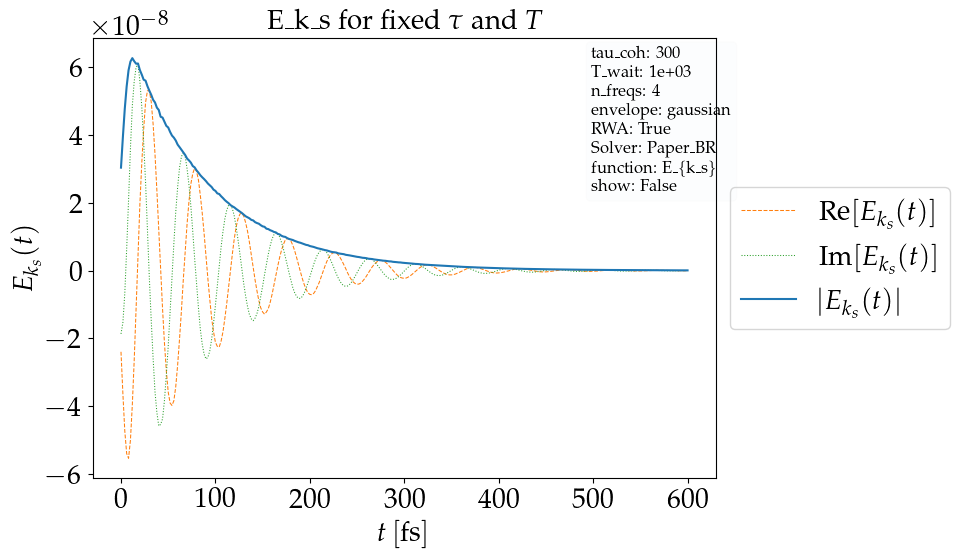

In [ ]:
# =============================
# LOAD AND PLOT 1D SPECTROSCOPY DATA
# =============================

### Find and load 1D data
file_path_1d = find_latest_file("1d_spectroscopy/Delta_cm_200", "1d_data_*.pkl")

if file_path_1d is not None:
    loaded_data = load_pickle_file(file_path_1d)
    
    if loaded_data is not None:
        # Extract 1D data
        t_det_vals = loaded_data['t_det_vals']
        data_avg   = loaded_data['data_avg']
        tau_coh    = loaded_data['tau_coh']
        T_wait     = loaded_data['T_wait']
        system     = loaded_data['system']
        n_freqs  = loaded_data['n_freqs']
        
        ### Display data information
        print(f"  τ_coh = {tau_coh:.2f} fs")
        print(f"  T_wait = {T_wait:.2f} fs")
        print(f"  t_det_vals: {len(t_det_vals)} points from {t_det_vals[0]:.2f} to {t_det_vals[-1]:.2f} fs")
        print(f"  data_avg shape: {data_avg.shape}")
        print(f"  ω_ats: {n_freqs} frequencies")
        print(f"  System parameters: {system}")
        
        ### Prepare plotting arguments
        output_dir = create_output_directory("1d_spectroscopy\Delta_cm_200")
        kwargs = {
            'tau_coh': tau_coh,
            'T_wait': T_wait,
            'n_freqs': n_freqs,
            'envelope': system.envelope_type,
            'RWA': system.RWA_laser,
            'Solver': system.ODE_Solver,
            'function': "E_{k_s}", # ONLY IF THE DATA comes from "parallel_compute_1d_E_with_inhomogenity",
            'show': False  # Don't show the plot yet, we'll save it first
        }
        
        ### Generate 1D plot
        print("📊 Generating 1D spectroscopy plot...")
        # Plot and get the figure object
        fig = Plot_fixed_tau_T(t_det_vals, data_avg, **kwargs)

        # Save the figure with a descriptive filename
        output_path = output_dir / f"1d_spectroscopy_{file_path_1d.stem}.png"
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ 1D plot saved to: {output_path}")a
        
        # Now display the plot
        plt.show()
        
    else:
        print("❌ Failed to load 1D spectroscopy data.")
else:
    print("   Please run the 1D spectroscopy calculation first to generate data.")


# 2. Process 2D Spectroscopy Data

✅ Found latest file: 2d_data_averaged.pkl
Loading data from: 2d_data_averaged.pkl
✅ Data loaded successfully!
  Loaded 1 2D datasets
  System data: SystemParameters(hbar=1.0, Boltzmann=1.0, atom_g=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]], atom_e=Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]], Temp=1.0, cutoff_=1.0, N_atoms=1, ODE_Solver='Paper_eqs', RWA_laser=True, E0=0.005, pulse_FWHM=15.0, t_max=600.0, dt=0.1, envelope_type='gaussian', omega_laser_cm=16000.0, Delta_cm=200, omega_A_cm=16005.288379215988, omega_B_cm=None, mu_A=1.0, mu_B=None, J_cm=None, gamma_0=0.0033333333333333335, gamma_phi=0.01, psi_ini=Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]])
📊 Plotting real component...


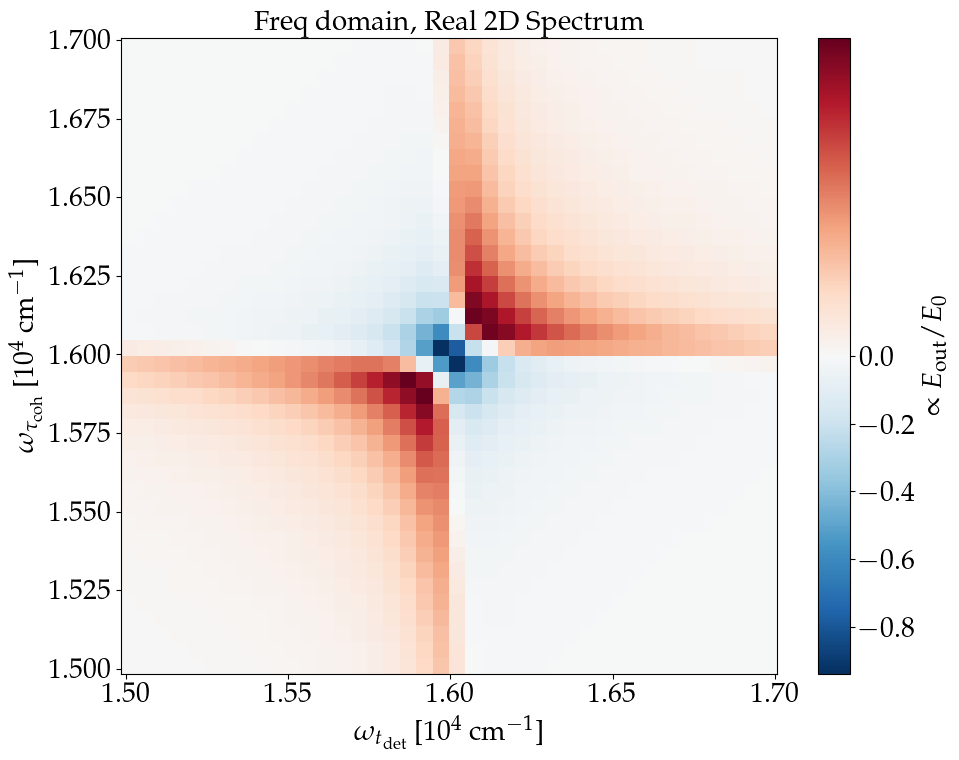

✅ real plot completed!
📊 Plotting abs component...


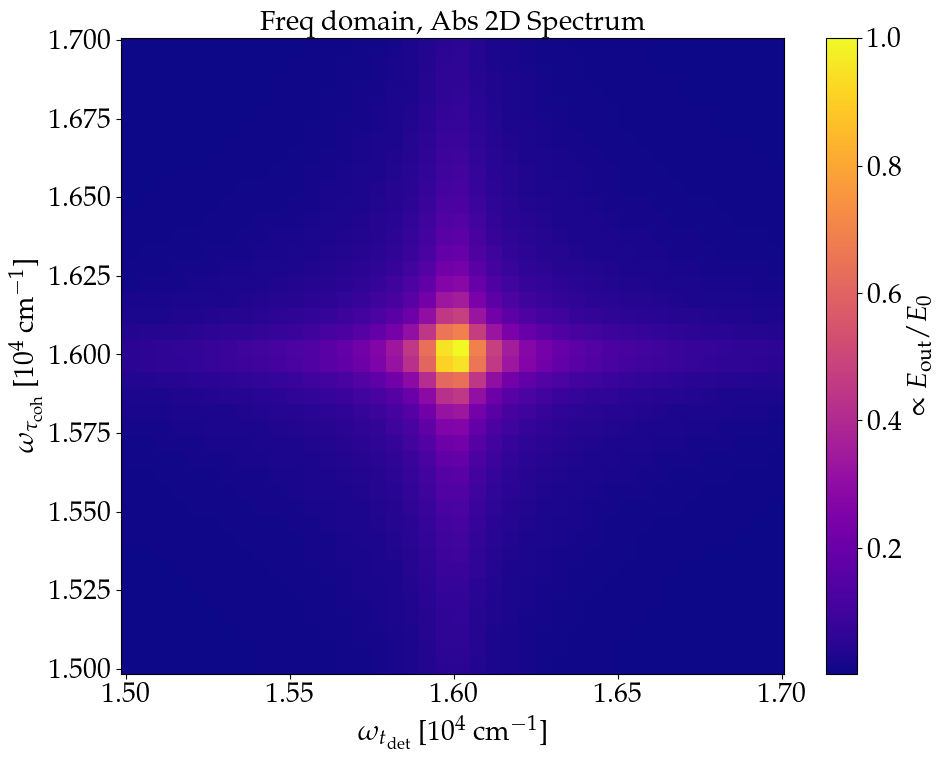

✅ abs plot completed!
📊 Plotting imag component...


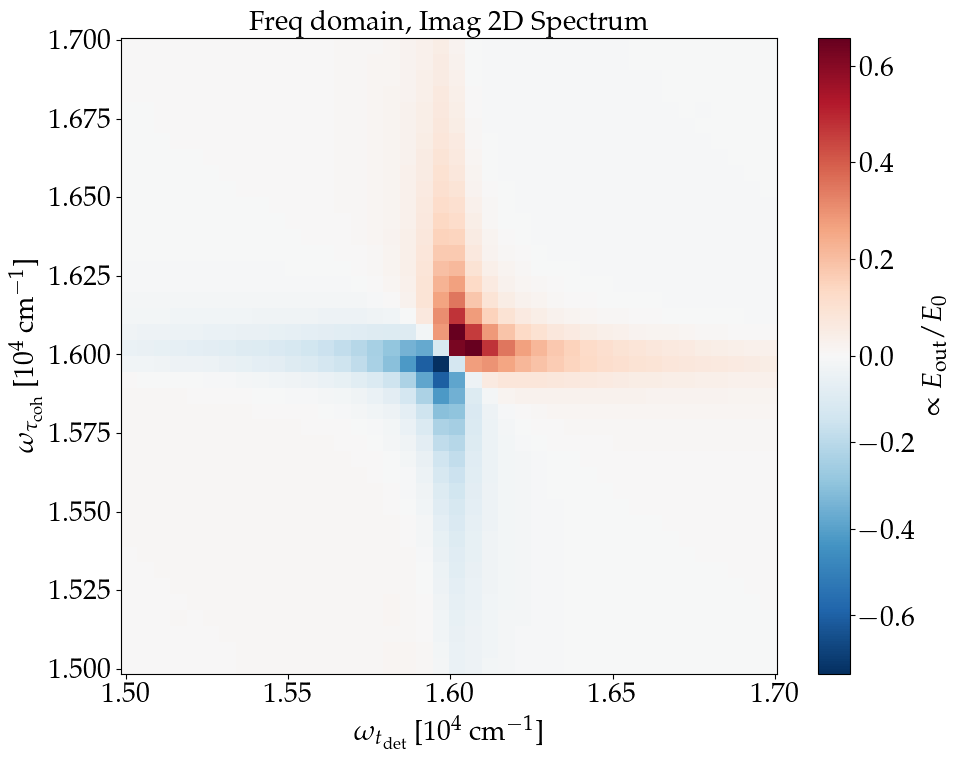

✅ imag plot completed!
📊 Plotting phase component...


In [ ]:
# =============================
# LOAD AND PLOT 2D SPECTROSCOPY DATA
# =============================

### Find and load 2D data
file_path_2d = find_latest_file("2d_spectroscopy/new_echo_signal/600fs/", "*d.pkl")

if file_path_2d is not None:
    loaded_data = load_pickle_file(file_path_2d)
    
    if loaded_data is not None:
        # Extract 2D data
        two_d_datas = loaded_data["two_d_datas"]
        times_T     = loaded_data["times_T"]
        times       = loaded_data["times"]
        system_data = loaded_data["system"]
        
        ### Display data information
        print(f"  Loaded {len(two_d_datas)} 2D datasets")
        print(f"  System data: {system_data}")
        
        ### Create output directory
        output_dir = create_output_directory("2d_spectroscopy/extended")
        
        from src.spectroscopy.calculations import get_tau_cohs_and_t_dets_for_T_wait
        t_det_vals, tau_coh_vals = get_tau_cohs_and_t_dets_for_T_wait(times, times_T[0])
        """
        Plot_2d_El_field(
            (t_det_vals, tau_coh_vals, two_d_datas[0]),
            save=True,  # CHANGE TO False for no plotting the Time domain
            output_dir=output_dir,
            system=system_data,
            use_custom_colormap=True,
        )
        """
        ### Plot each component type
        plot_types = ["real", "abs", "imag", "phase"]
        
        for plot_type in plot_types:
            print(f"📊 Plotting {plot_type} component...")
            
            plot_args = {
                "domain": "freq",
                "type": plot_type,
                "save": True,
                "output_dir": output_dir,
                "use_custom_colormap": True,
                "section": (1.5, 1.7, 1.5, 1.7),  # Plot the first section
                "system": system_data,
            }
            
            try:
                extend_and_plot_results(
                    two_d_datas,
                    times_T=times_T,
                    times=times,
                    extend_for=(1, 1.6),
                    **plot_args,
                )
                print(f"✅ {plot_type} plot completed!")
                
            except Exception as e:
                print(f"❌ Error plotting {plot_type}: {e}")
        
        print(f"🎯 All 2D plots saved to: {output_dir}")
        
    else:
        print("❌ Failed to load 2D spectroscopy data.")
else:
    print("   Please run the 2D spectroscopy calculation first to generate data.")

In [ ]:
# =============================
# DEMONSTRATION: AVERAGE MULTIPLE PICKLE FILES
# =============================

### Define the path to your data directory
data_subdir = "1d_spectroscopy/Delta_cm_200"  # Adjust this to your actual data directory
data_dir = DATA_DIR / data_subdir

### Use the averaging function
if data_dir.exists():
    print(f"Processing files in: {data_dir}")
    
    # Generate a descriptive output filename
    output_filename = "averaged_1d_data.pkl"
    
    # Specify a pattern to match specific files (e.g., only 1d_data_*.pkl files)
    file_pattern = "1d_data_*.pkl"
    
    # Call the averaging function with appropriate parameters
    averaged_data = average_data_1d(
        str(data_dir),
        file_pattern=file_pattern,
        output_filename=output_filename
    )
    
    if averaged_data is not None:
        # Display information about the averaged data
        print("\n📊 Averaged Data Information:")
        print(f"  τ_coh = {averaged_data['tau_coh']:.2f} fs")
        print(f"  T_wait = {averaged_data['T_wait']:.2f} fs")
        print(f"  t_det_vals: {len(averaged_data['t_det_vals'])} points")
        print(f"  data_avg shape: {averaged_data['data_avg'].shape}")
        print(f"  Total frequencies: {averaged_data['n_freqs']}")
        
        # Plot the averaged data
        output_dir = create_output_directory(data_subdir)
        kwargs = {
            'tau_coh': averaged_data['tau_coh'],
            'T_wait': averaged_data['T_wait'],
            'n_freqs': averaged_data['n_freqs'],
            'envelope': averaged_data['system'].envelope_type,
            'RWA': averaged_data['system'].RWA_laser,
            'Solver': averaged_data['system'].ODE_Solver,
            'function': "E_{k_s}",
            'show': True  # Show the plot
        }
        
        print("\n📈 Plotting averaged data...")
        fig = Plot_fixed_tau_T(averaged_data['t_det_vals'], averaged_data['data_avg'], **kwargs)
        
        # Save the figure
        output_path = output_dir / f"averaged_1d_spectroscopy.png"
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Averaged plot saved to: {output_path}")
else:
    print(f"❌ Data directory does not exist: {data_dir}")
    print("Please specify a valid data directory.")

In [ ]:
# =============================
# DEMONSTRATION: AVERAGE MULTIPLE 2D PICKLE FILES
# =============================

### Define the path to your 2D data directory
data_subdir_2d = "2d_spectroscopy/new_echo_signal/600fs/"  # Adjust this to your actual 2D data directory
data_dir_2d = DATA_DIR / data_subdir_2d

### Use the 2D averaging function
if data_dir_2d.exists():
    print(f"Processing files in: {data_dir_2d}")
    
    # Generate a descriptive output filename
    output_filename = "averaged_2d_data.pkl"
    
    # Specify a pattern to match specific files
    file_pattern = "*d.pkl"  # This will match both "2d.pkl" and similar patterns
    
    # Call the averaging function with appropriate parameters
    averaged_data_2d_result = average_data_2d(
        str(data_dir_2d),
        file_pattern=file_pattern,
        output_filename=output_filename
    )
    
    if averaged_data_2d_result is not None:
        # Display information about the averaged data
        print("\n📊 Averaged 2D Data Information:")
        print(f"  Times: {len(averaged_data_2d_result['times'])} points")
        print(f"  Times_T: {averaged_data_2d_result['times_T']}")
        print(f"  Number of T wait times: {len(averaged_data_2d_result['two_d_datas'])}")
        print(f"  Shape of each 2D array: {averaged_data_2d_result['two_d_datas'][0].shape}")
        print(f"  Total frequencies: {averaged_data_2d_result['n_freqs']}")
        
        ### Create output directory for plots
        output_dir = create_output_directory("2d_spectroscopy/averaged")
        
        ### Plot the averaged 2D data
        from src.spectroscopy.calculations import get_tau_cohs_and_t_dets_for_T_wait
        t_det_vals, tau_coh_vals = get_tau_cohs_and_t_dets_for_T_wait(
            averaged_data_2d_result['times'], 
            averaged_data_2d_result['times_T'][0]
        )
        
        ### Plot each component type
        plot_types = ["real", "abs", "imag", "phase"]
        
        for plot_type in plot_types:
            print(f"📊 Plotting {plot_type} component...")
            
            plot_args = {
                "domain": "freq",
                "type": plot_type,
                "save": True,
                "output_dir": output_dir,
                "use_custom_colormap": True,
                "section": (1.5, 1.7, 1.5, 1.7),  # Adjust based on your data
                "system": averaged_data_2d_result['system'],
            }
            
            try:
                extend_and_plot_results(
                    averaged_data_2d_result['two_d_datas'],
                    times_T=averaged_data_2d_result['times_T'],
                    times=averaged_data_2d_result['times'],
                    extend_for=(1, 1.6),  # Adjust based on your data
                    **plot_args,
                )
                print(f"✅ {plot_type} plot completed!")
                
            except Exception as e:
                print(f"❌ Error plotting {plot_type}: {e}")
        
        print(f"🎯 All averaged 2D plots saved to: {output_dir}")
else:
    print(f"❌ Data directory does not exist: {data_dir_2d}")
    print("Please specify a valid data directory.")